## Methods

Decision trees are a supervised learning model which can be used for either classification or regression. A decision tree is a model that follows a certain sequence of rules which form many different paths creating a branching structure that can be followed down from the top to the bottom to classify a data point with certain feautures into one of the available labels. The process starts with a root node that is alone at the top of the branching structure. At the root node, a rule is defined that will provide one of two outcomes for any given data point based on its features. Each of the two outcomes corresponds to one of the branching paths. Each path will lead to another node that will again have a defined rule that splits the data into one of two pathways. This process continues for any number of nodes until a  terminal node is reached where one of the two outcomes from the rule is assigning a value of the target variable.

Decision tree models are trained on a labelled set of training data and without defined hyperparameters they will split all of the given training data into nodes until all of the terminal nodes are pure meaning all of the data points at that node have the same value of the target variable. If there is a mix of different target variables values than the node is called impure. When the decision tree is being formed, a good split of the data is one where the two nodes the data is split into have purer class distribution. The purity of the node can be measured using a metric called the Gini Impurity score. Gini Impurity takes on a value between 0 and 0.5. The Gini Impurity for the split is calculated by taking a weighted average of the Gini Impurities of the datasets at the leaves. The best split is determined by calculating the gain for each split option. The gain is caluclated by subtracting the Gini Impurity after the data is split from the Gini impurity of all of the data before splitting.

Decision trees are relatively prone to overfitting, but pruning by hyperparameter tuning can be used to resolve this issue. Pruning reduces the size of the tree through several different methods reducing the complexity of the tree. One hyperparameter that can be adjusted is the maximum number of layers. The maximum number of the layers is the number of nodes the tree can have before it will stop being split. Another one is setting a minimum number of samples that is required to split a node. Both of these methods of pruning help combat overfitting to improve predictive accuracy by removing sections of the trees that are less important of redundant.

## Class Distribution

To start the process of building a decision tree that will classify NHL teams into playoff teams or nonplayoff teams based on expected goals for, corsi, shot attempts, expected goals for, faceoffs won, takeaways, giveaways, and hits I loaded in my normalized and labelled data and determined the distribution of each type of team within the five seasons of team data.

In [1]:
import numpy as np
import pandas as pd

In [69]:
df=pd.read_csv("../data/01-modified-data/team_pp_data_clean.csv")
label = df['playoff'].copy()
distribution=df.groupby('playoff').size()
df=df.drop(columns=['Unnamed: 0','playoff'])
features=df.columns
feature_matrix = df[features].copy()
print("Frequency of each value of playoff variable: ",distribution)


Frequency of each value of playoff variable:  playoff
0    62
1    64
dtype: int64


The split of the dataset into playoff or non-playoff team is almost an even split.

## Baseline Model

As a baseline model to compare the results of the decision tree to, I ran a random classifier function on the data.

In [41]:
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); 
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

In [42]:
random_classifier(label)

-----RANDOM CLASSIFIER-----
count of prediction: dict_values([59, 67])
probability of prediction: [0.46825397 0.53174603]
accuracy 0.5158730158730159
percision, recall, fscore, (array([0.50746269, 0.52542373]), array([0.5483871, 0.484375 ]), array([0.52713178, 0.50406504]), array([62, 64]))


The random classifier has a relatively high accuracy score of around 0.5 indicating that assigning the class label randomly has a 1 in 2 shot of being accurate. This is pretty good for a random classifier, maybe because the class distribution in the data is 50-50, but using a good decision tree should provide better results.

## Model Tuning

After running the baseline random classifier model, I will run a decision tree model on the set of training data without modifying any of the hyperparameters.

In [60]:
from sklearn.model_selection import train_test_split

X = feature_matrix
y= label

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=100
)

print(type(X_train),X_train.shape)
print(type(X_test),X_test.shape)
print(type(y_train),y_train.shape)
print(type(y_test),y_test.shape)

<class 'pandas.core.frame.DataFrame'> (100, 8)
<class 'pandas.core.frame.DataFrame'> (26, 8)
<class 'pandas.core.series.Series'> (100,)
<class 'pandas.core.series.Series'> (26,)


1.0
1.0
1.0
1.0
0.7307692307692307
0.75
0.8
0.7741935483870969


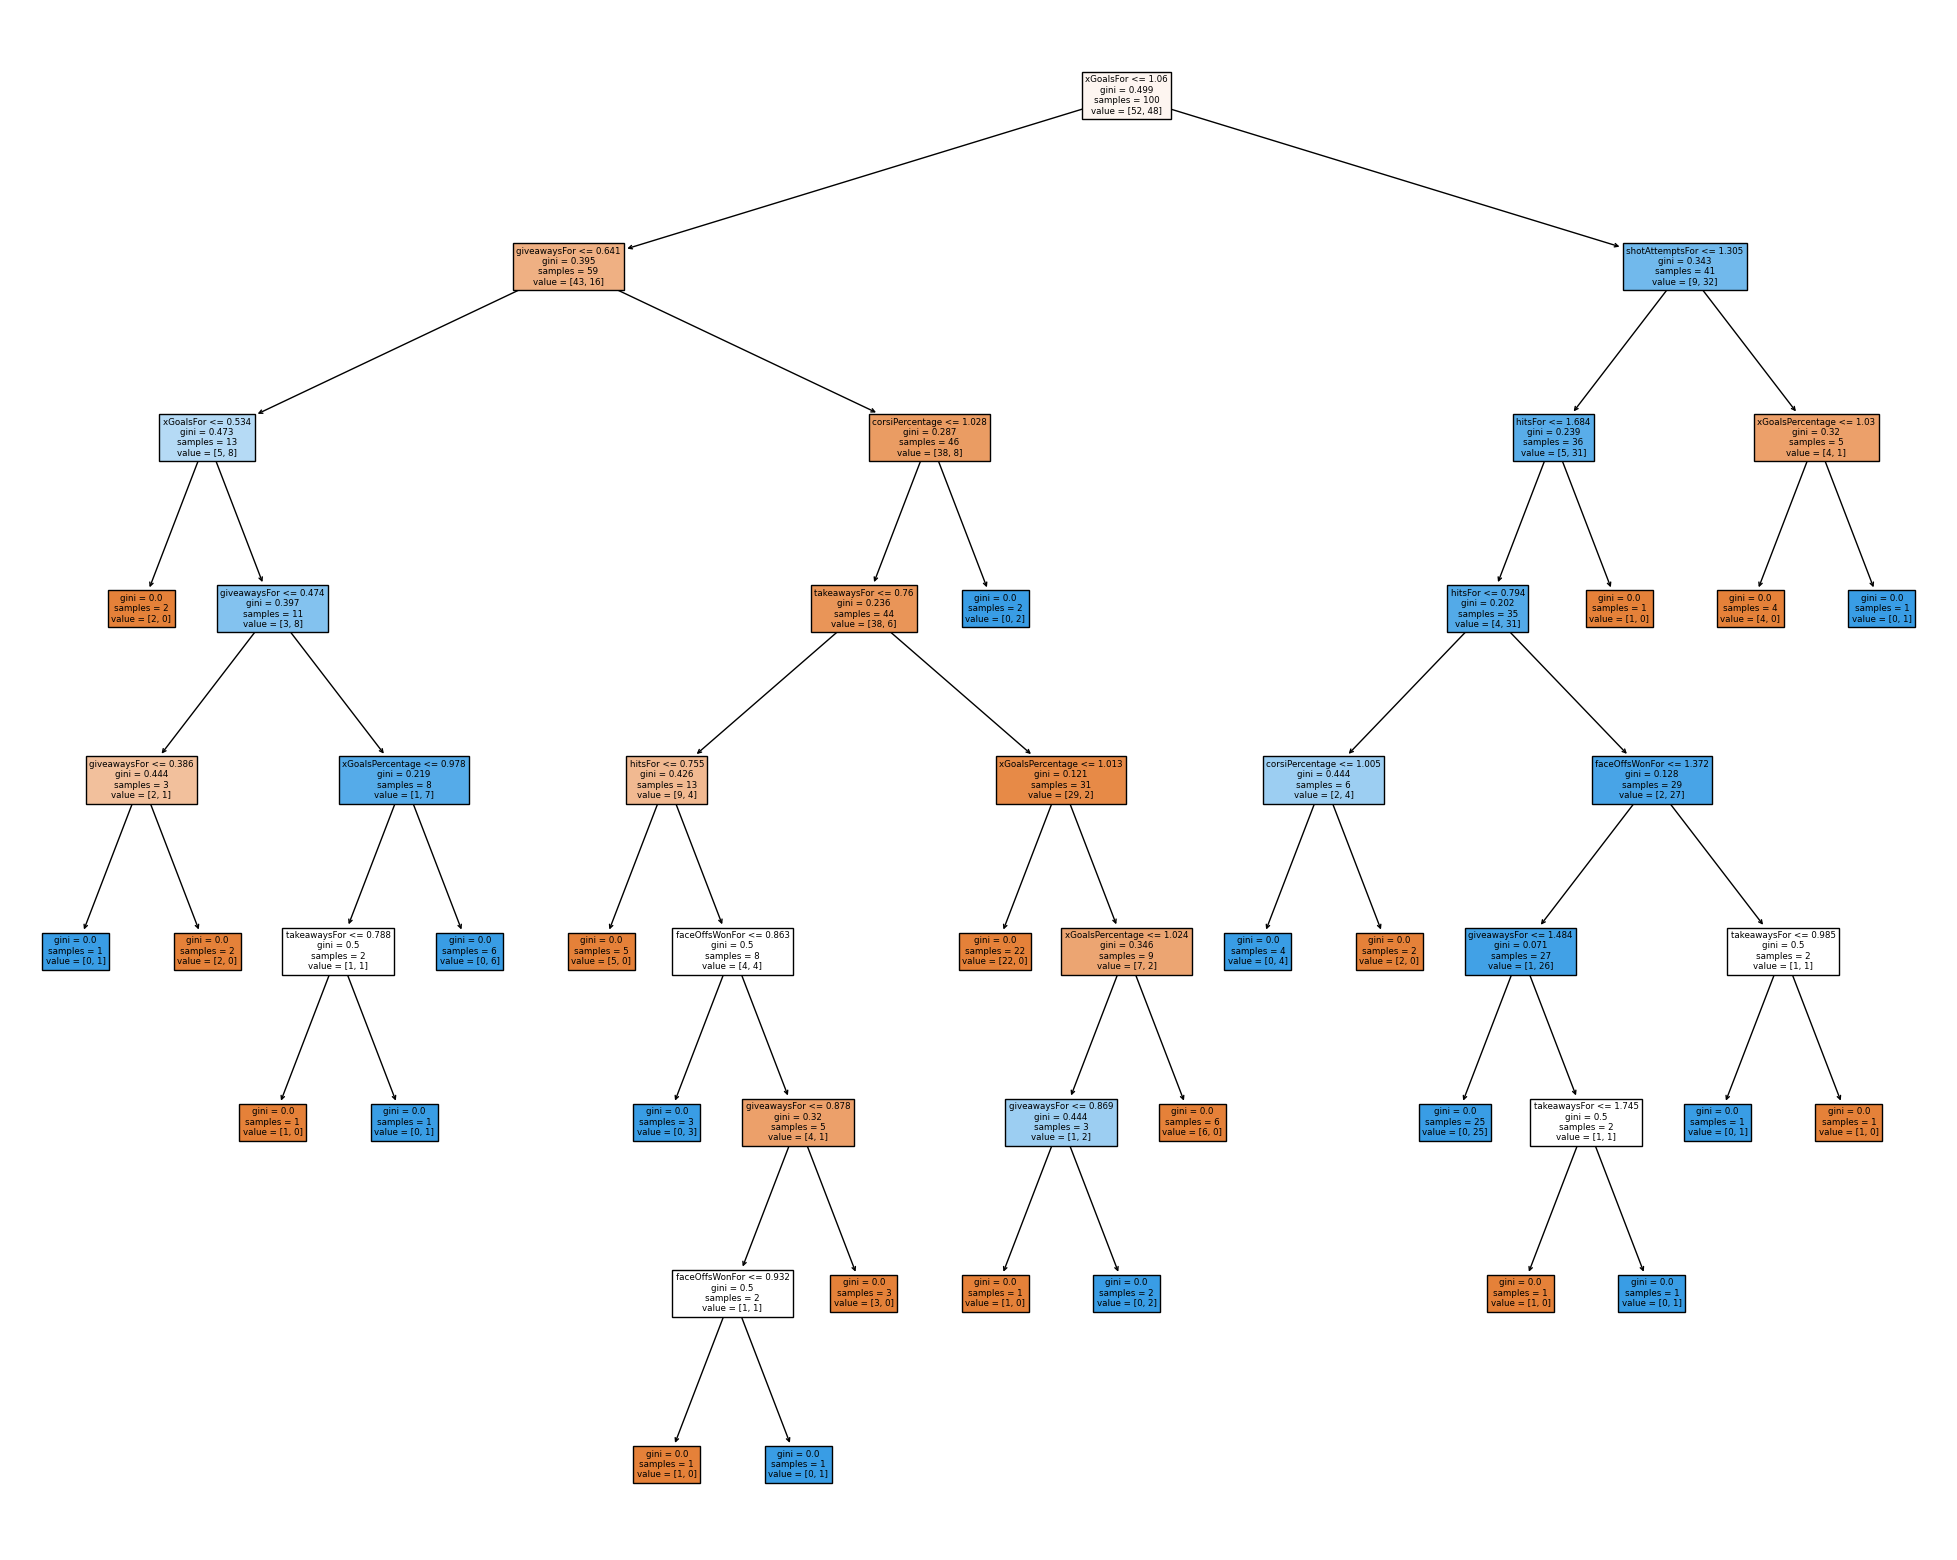

In [61]:
from sklearn import tree
import sklearn.metrics

model=tree.DecisionTreeClassifier()
model=model.fit(X_train,y_train)

yp_train = model.predict(X_train)
yp_test = model.predict(X_test)

#training data
print(sklearn.metrics.accuracy_score(y_true=y_train, y_pred=yp_train))
print(sklearn.metrics.recall_score(y_true=y_train, y_pred=yp_train))
print(sklearn.metrics.precision_score(y_true=y_train, y_pred=yp_train))
print(sklearn.metrics.f1_score(y_true=y_train, y_pred=yp_train))

#test data
print(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=yp_test))
print(sklearn.metrics.recall_score(y_true=y_test, y_pred=yp_test))
print(sklearn.metrics.precision_score(y_true=y_test, y_pred=yp_test))
print(sklearn.metrics.f1_score(y_true=y_test, y_pred=yp_test))

fig = plt.figure(figsize=(25,20))
__=tree.plot_tree(model, feature_names=list(features),filled=True)


The baseline decision tree model resulted in an accuracy score of around 71% for the test data that had been partitioned from the original dataset. This is definitely an improvement over the baseline random classifer model, but the training data had an accuracy score of 100% which may indicate that overfitting is occuring. Another indication of over fitting is the very small number of samples in most of the terminal nodes on the decision tree. To adjust for overfitting, we can look at different values of the maximum number of layers and see which values results in the best balance of accuracy between training and test data. The number of layers that the baseline decision tree model used was 9, so I will evaluate the model accuracy with max_depth ranging from 0 to 10.

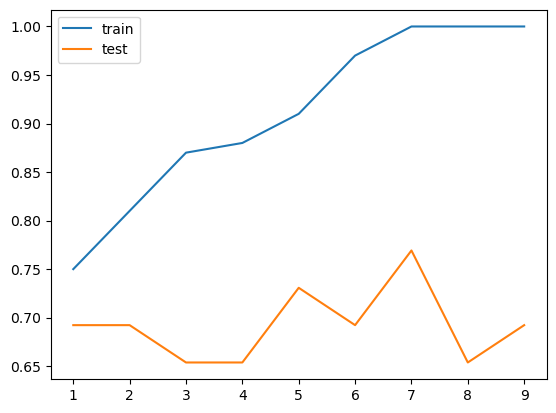

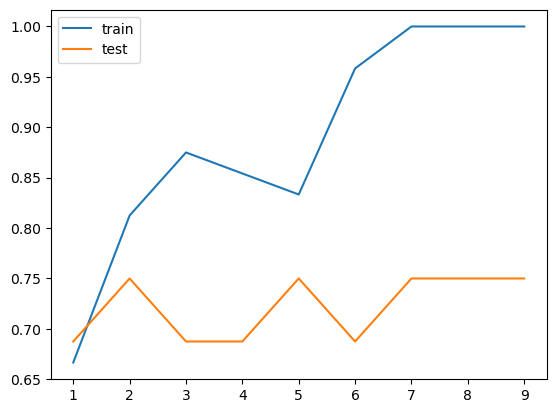

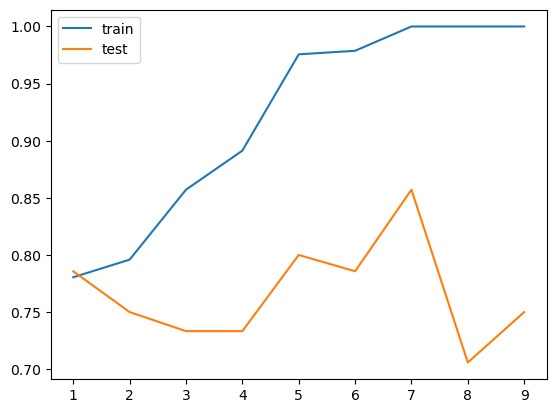

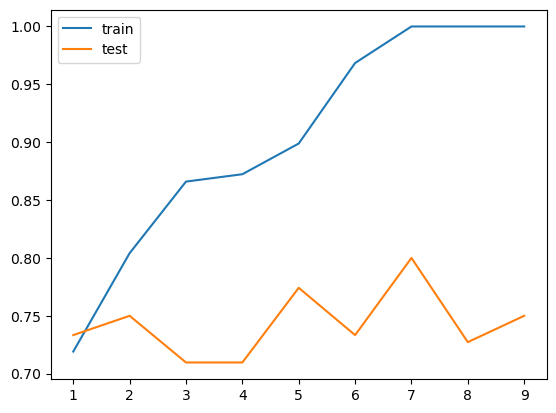

In [63]:
test_results=[]
train_results=[]

for num_layer in range (1,10):
    model=tree.DecisionTreeClassifier(max_depth=num_layer)
    model=model.fit(X_train,y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)
    
    test_results.append([num_layer,sklearn.metrics.accuracy_score(y_test, yp_test),sklearn.metrics.recall_score(y_test, yp_test),sklearn.metrics.precision_score(y_test, yp_test),sklearn.metrics.f1_score(y_test, yp_test)])
    train_results.append([num_layer,sklearn.metrics.accuracy_score(y_train, yp_train),sklearn.metrics.recall_score(y_train, yp_train),sklearn.metrics.precision_score(y_train, yp_train),sklearn.metrics.f1_score(y_train, yp_train)])


df_test_results=pd.DataFrame(test_results)
df_test_results.columns=['num_layers','accuracy_score','recall_score','precision_score','f_score']

df_train_results=pd.DataFrame(train_results)
df_train_results.columns=['num_layers','accuracy_score','recall_score','precision_score','f_score']

dfTuning=pd.merge(df_train_results,df_test_results,how="inner",on='num_layers')
dfTuning.columns=['num_layers','accuracy_score_tr','recall_score_tr','precision_score_tr','f_score_tr','accuracy_score_te','recall_score_te','precision_score_te','f_score_te']

plt.plot(dfTuning['num_layers'],dfTuning['accuracy_score_tr'],label="train")
plt.plot(dfTuning['num_layers'],dfTuning['accuracy_score_te'],label="test")
plt.legend()
plt.show()

plt.plot(dfTuning['num_layers'],dfTuning['recall_score_tr'],label="train")
plt.plot(dfTuning['num_layers'],dfTuning['recall_score_te'],label="test")
plt.legend()
plt.show()

plt.plot(dfTuning['num_layers'],dfTuning['precision_score_tr'],label="train")
plt.plot(dfTuning['num_layers'],dfTuning['precision_score_te'],label="test")
plt.legend()
plt.show()

plt.plot(dfTuning['num_layers'],dfTuning['f_score_tr'],label="train")
plt.plot(dfTuning['num_layers'],dfTuning['f_score_te'],label="test")
plt.legend()
plt.show()

Above are graphs showing various metrics for the quality of the model based on the number of layers. There metrics for the test data all seem to fluctaute around about the same value regardless of the number of layers, but appear to be the highest at maximum depth of 7. 

## Final Results

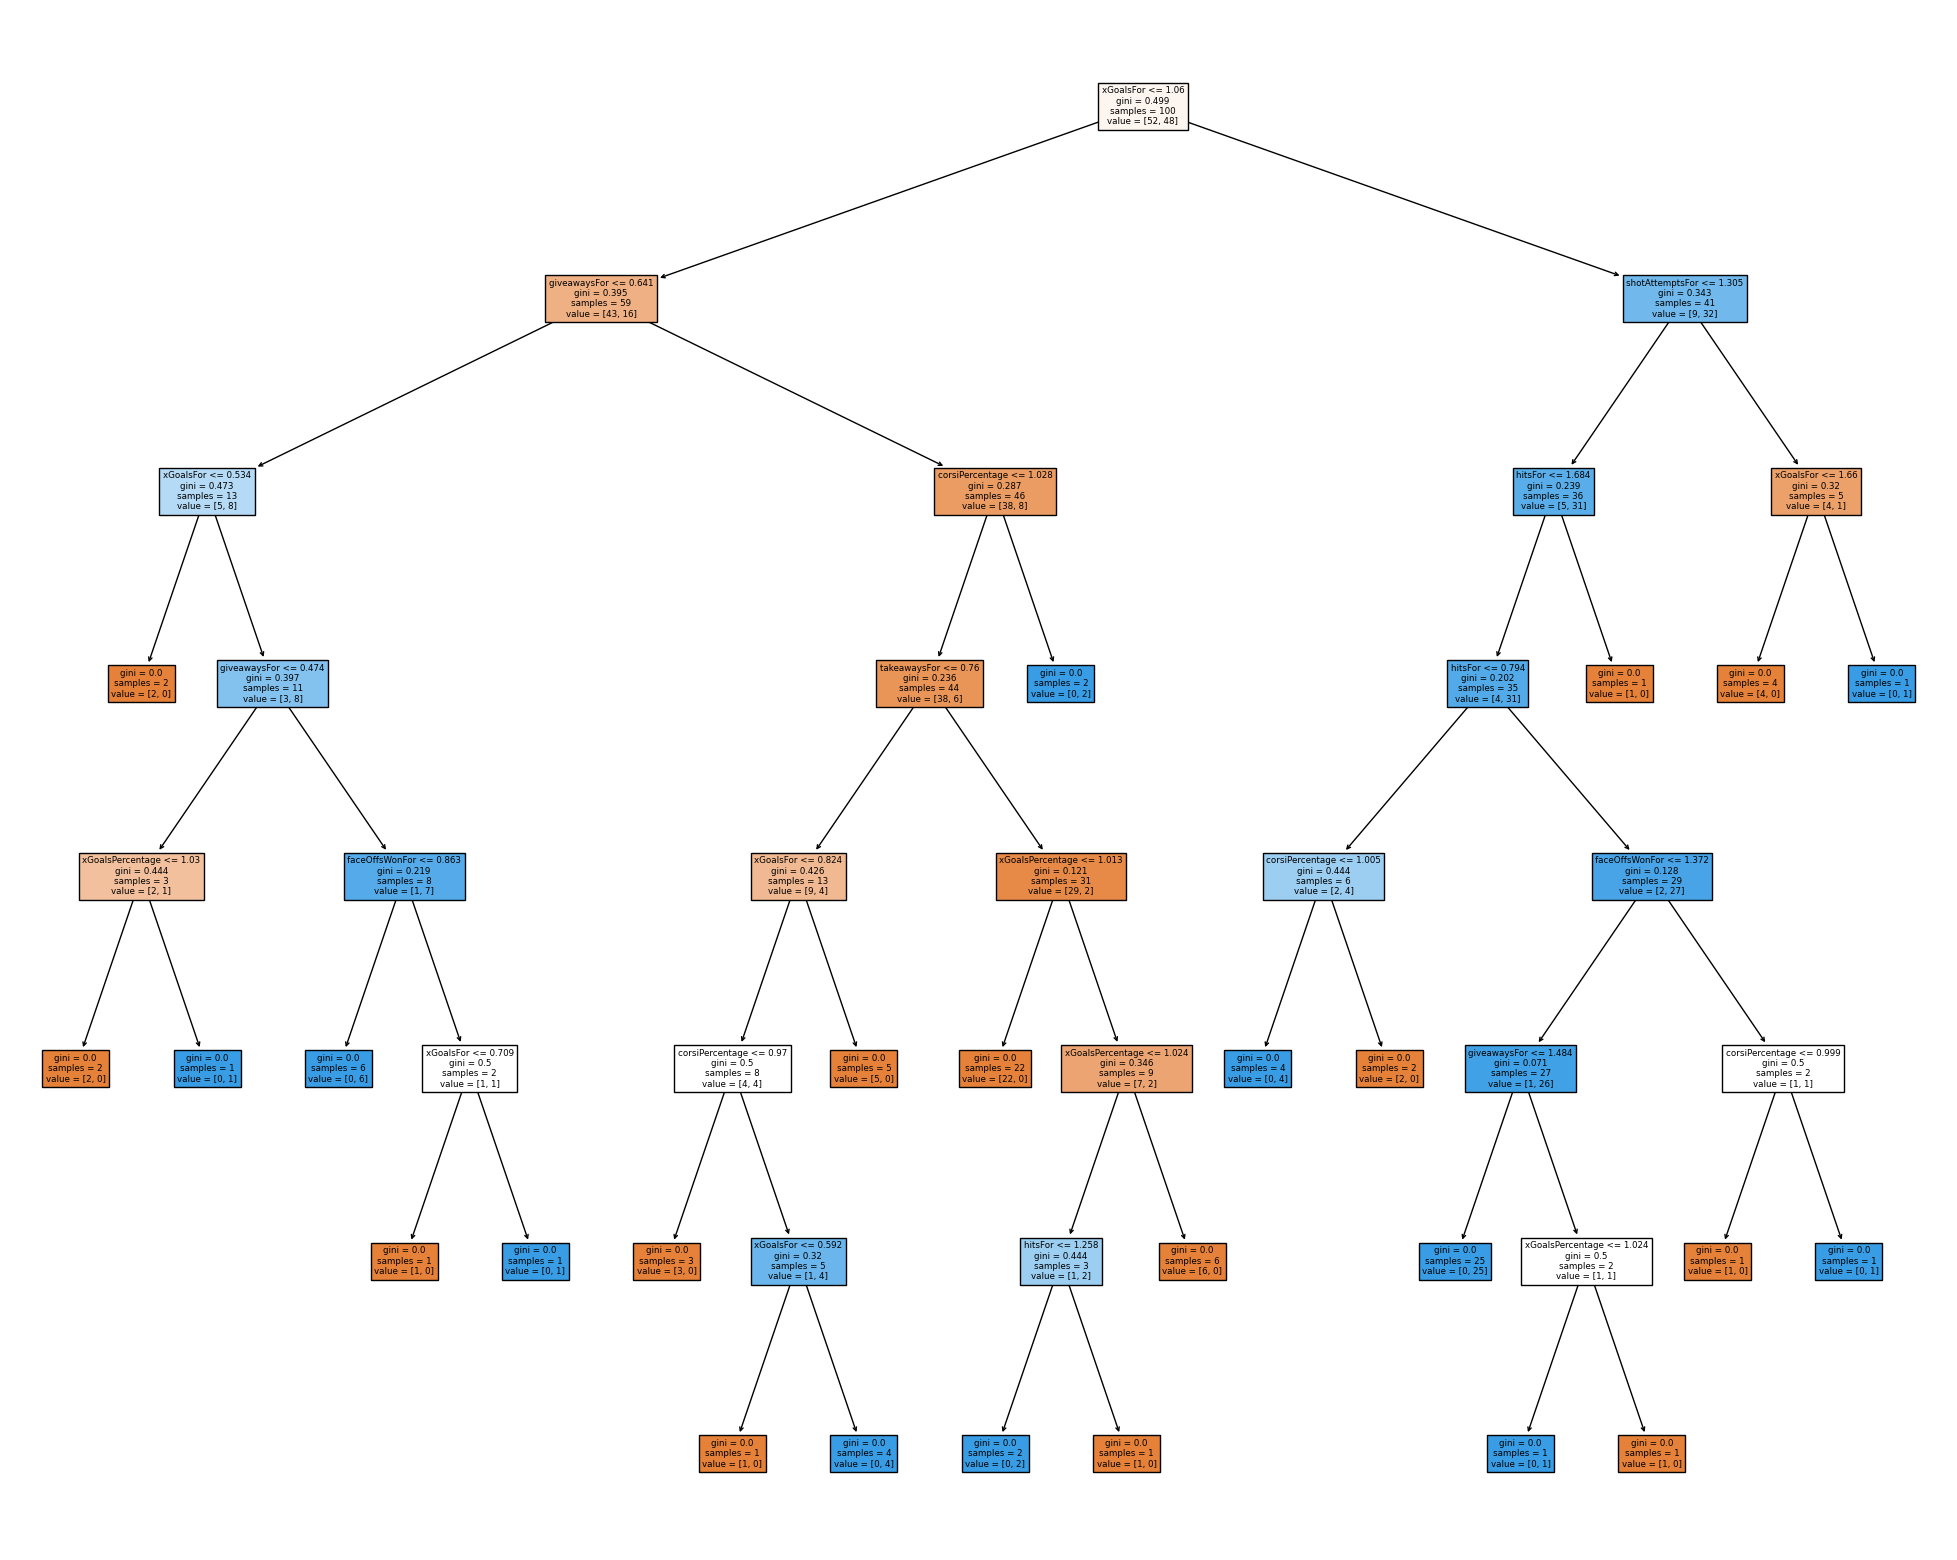

In [70]:
model = tree.DecisionTreeClassifier(max_depth=7)
model = model.fit(X_train, y_train)

yp_train=model.predict(X_train)
yp_test=model.predict(X_test)

fig = plt.figure(figsize=(25,20))
__=tree.plot_tree(model, feature_names=list(features),filled=True)

In [66]:
#training data
print("Training accuracy score:",sklearn.metrics.accuracy_score(y_true=y_train, y_pred=yp_train))
print("Training recall score:",sklearn.metrics.recall_score(y_true=y_train, y_pred=yp_train))
print("Training precision score:",sklearn.metrics.precision_score(y_true=y_train, y_pred=yp_train))
print("Training f score:",sklearn.metrics.f1_score(y_true=y_train, y_pred=yp_train))

#test data
print("Test accuracy score:",sklearn.metrics.accuracy_score(y_true=y_test, y_pred=yp_test))
print("Test recall score:",sklearn.metrics.recall_score(y_true=y_test, y_pred=yp_test))
print("Test precision score:",sklearn.metrics.precision_score(y_true=y_test, y_pred=yp_test))
print("Test f score:",sklearn.metrics.f1_score(y_true=y_test, y_pred=yp_test))

Training accuracy score: 1.0
Training recall score: 1.0
Training precision score: 1.0
Training f score: 1.0
Test accuracy score: 0.7307692307692307
Test recall score: 0.6875
Test precision score: 0.8461538461538461
Test f score: 0.7586206896551724


Using the optimal value of maximum layers resulted in an accuracy score of 73% on the test data, however the accuracy score of the training data is still 100% so there is still some degree of overfitting. This may be able to be resolved by using data from a greater number of seasons in the original dataset.

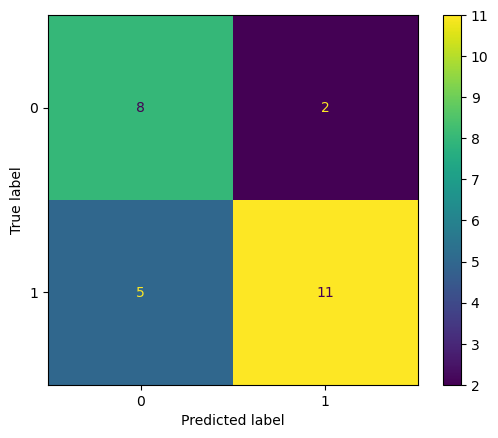

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_plot(y_data, y_pred):
    cm=confusion_matrix(y_data,y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

cm=confusion_matrix(y_test, yp_test)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In the above confusion matrix, the label 1 corresponds with teams that make the playoffs and 0 corresponds with teams who do not make the playoffs. As seen in the matrix, the model seems to be better at predicting teams that miss the playoffs; only two of the teams that made did not make the playoffs were predicted to be playoff teams. For teams that did make the playoffs, five out of sixteen were assigned the label of non-playoff team. The decision tree model had an even split (13-13) of the two assigned labels which aligns with the distribution of the two labels in the larger dataset, but the test data set had an actual distribution of 16 to 10.

## Conclusions

In the optimally-fit decision tree model, the most common feature to split the data on is expected goals for. It is used much more frequently than any measure of defensive success of a team. This indicates that expected goals for may be a measure that really separates playoff teams from non-playoff teams in the NHL. Of note, this data is only from power play situations which are a heavily offensively driven game situation so investigation into whether this holds true for expected goals compared to defensive metrics in regular five on five play may reveal just how important high quality defense is and whether or not it can be made up for by strong offensive ability on powerplays.

The confusion matrix of the optimally-fit model indicates that this model has better predictive power for teams that did not make the playoffs than teams that did make the playoffs. This may indicate that teams that miss out on making the playoffs are more similar to one another than the group of teams that do make the playoffs. There may be a greater degree of variability in playoff teams with the very best teams that are at the top of their conferences having a larger gap over teams that squeak in in wildcard slots than wildcard slots have over teams that miss out. Further investigation by removing teams that clinch playoff spots or are eliminated a month before they start may provide more valuable insights in comparing teams that are fighting for playoff spots during the last couple of weeks. A model trained on this data may be able to pick up on more nuance because the teams will be more similar to each other when the extremes are excluded. 